# Zipf’s and Gibart’s Laws

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.neighbors
from sklearn.neighbors import KernelDensity
import scipy
from matplotlib import pyplot as plt
from scipy.stats import pareto
from scipy.optimize import fsolve
from tabulate import tabulate

In [2]:
data = pd.read_csv("/Users/brunokomel/Downloads/US_supermarkets.csv")
df = pd.DataFrame(data, columns=['firm','number_of_stores'])

In [3]:
display(df)

,firm,number_of_stores
0,114 Grocery & Deli Incorporated,1
1,1st Oriental Supermarket,2
2,A & A Fine Foods,1
3,A & G Fine Foods Incorporated,1
4,A & P Food Stores,109
...,...,...
632,White Market,5
633,Whites Fresh Foods,13
634,Whole Foods Market,68
635,Winco,14


In [4]:
print(len(df.firm.unique()))
print(len(df))
#so there are no stores with repeated values (although from looking at the data some of these are really close)

637
637


(array([ 38., 104.,   0., 123.,  53.,  81.,  59.,  44.,  25.,  24.,  19.,
         15.,  10.,  17.,   6.,   6.,   1.,   3.,   3.,   4.,   1.,   1.]),
 array([0.        , 0.35728114, 0.71456228, 1.07184342, 1.42912456,
        1.78640569, 2.14368683, 2.50096797, 2.85824911, 3.21553025,
        3.57281139, 3.93009253, 4.28737367, 4.64465481, 5.00193595,
        5.35921708, 5.71649822, 6.07377936, 6.4310605 , 6.78834164,
        7.14562278, 7.50290392, 7.86018506]),
 <BarContainer object of 22 artists>)

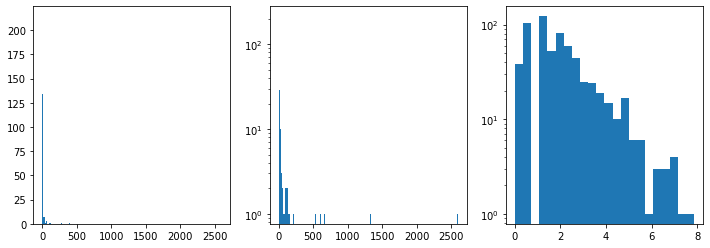

In [5]:
fig, (ax0,ax1,ax2) = plt.subplots(ncols =3, figsize =(12,4))

ax0.hist(df.number_of_stores, bins = 'auto')
ax1.hist(df.number_of_stores, bins = 'auto', log = True)
ax2.hist(np.log(df.number_of_stores), bins = 'auto' , log = True)

## 1. State Zipf’s Law. Why does Zipf’s Law suggest that certain variables have a Pareto distribution?


Zipfs law, which originally concerns frequency of words in liguistics, states that given some population, the frequency of any event is inversely proportional to its rank in the frequency table. More clearly, the most frequent event occurs about twice as often as the second most frequent event, three times as often as the third most frequent event, etc. 

Zipf's law suggests that certain variables follow a Pareto distribution because it is analogous to the continous Pareto distribution in the same way that the discrete uniform distribution is analogous to the continuous uniform distribution (from Wikipedia). 

## 2. State Gibart’s Law. Why does Gibart’s Law suggest that certain variables have a Log-Normal distribution?


Gilbart's law states that the proportional rate of growth of a firm is independent of its absolute size, thus the law of proportional growth gives rise to a firm size distribution that is log-normal (from Wikipedia).

## 3. Let Si be the number of stores that a supermarket chain i has. Estimate the density of S using a kernel density estimator. Indicate your choice of kernel function and bandwidth and justify these selections.


In [6]:
#display(df.number_of_stores[:])
#type(df.number_of_stores)
(df['number_of_stores'])
df.head()

,firm,number_of_stores
0,114 Grocery & Deli Incorporated,1
1,1st Oriental Supermarket,2
2,A & A Fine Foods,1
3,A & G Fine Foods Incorporated,1
4,A & P Food Stores,109


In [7]:
df.number_of_stores

0        1
1        2
2        1
3        1
4      109
      ... 
632      5
633     13
634     68
635     14
636    608
Name: number_of_stores, Length: 637, dtype: int64

In [8]:
num_stores = df[['number_of_stores']].to_numpy()
np.shape(num_stores)

(637, 1)

In [9]:
#Next we need to find the optimal bandwidth. We choose to do that by Silverman's rule of thumb.
q1, q3 = np.percentile(df.number_of_stores, [25,75])
iqr = q3-q1

silvermans_hn = 0.9*np.minimum(np.var(num_stores),iqr/1.35)*len(num_stores)**(-1/5)
bw = silvermans_hn

In [10]:
def normal(x):
    return((1/np.sqrt(2*np.pi))*np.exp(-(1/2)*(x**2)))

In [11]:
# Noting that the choice of kernel estimator is not as important as the choice of bandwidth
# we choose the Gaussian density estimator:
grid = np.linspace(0,2600,2600)
def kde_gauss(S,h):
    density = []
    n = len(S)
    for j in grid:
        sum = 0
        i = 0
        while i <= n-1:
            sum += ((1/np.sqrt(2*np.pi))*np.exp(-(1/2)*((S[i] - j)/h)**2))
            i += 1
        f = sum/(n*h)
        density.append(f)
    return density

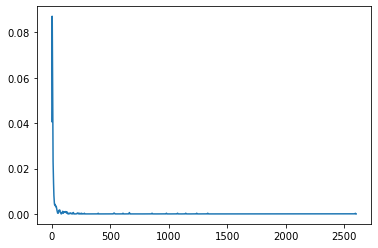

In [12]:
# And next we plot our Kernel estimator
f_normal_hs = kde_gauss(num_stores,bw)
fig, ax = plt.subplots()
ax.plot(grid,f_normal_hs)

(-200.0, 2692.0)

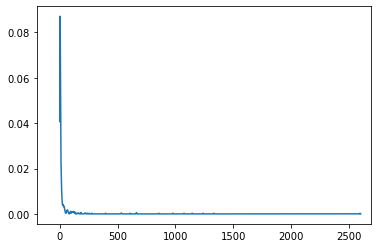

In [13]:
# Here we use a built in function to check if our results are correct:
kde = KernelDensity(kernel = 'gaussian', bandwidth = bw).fit(num_stores)
X_plot = np.linspace(0, 2600, 2600)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)


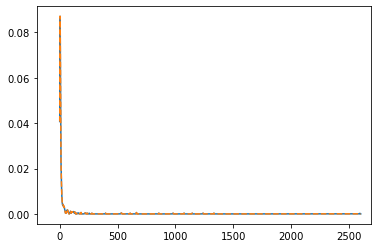

In [14]:
#And overlaying the two to compare:
# Here we use a built in function to check if our results are correct:
kde = KernelDensity(kernel = 'gaussian', bandwidth = bw).fit(num_stores)
X_plot = np.linspace(0, 2600, 2600)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)
plt.plot(grid,f_normal_hs, lw = 1.5, linestyle = "--")

#Our results are very close

## 4. Using a GMM estimate the Pareto distribution that fits the data. Report your results.

In [15]:
x̄ = np.mean(num_stores)
xₘ = np.min(num_stores)
n = len(num_stores)

As we are working with a Pareto distribution, we know we need to estimate two parameters that are not moments of the distribution. Thus, we resort to Method of Moments to estimate the moments, but then we solve for the parameters separately. Following Kotz et. al. 1970:

$$E(x) = \bar{x} = \frac{\alpha \hat{x}_\min}{\alpha-1} $$

And:

$$\bar{x}_\min = \frac{n\alpha \hat{x}_\min}{n\alpha - 1} $$

Where $\hat{x}_\min$ is the estimator for the $\min$ parameter, $\bar{x}$ is the sample mean, and $\bar{x}_\min$ is the sample $\min$.

Then we can solve these two equations to get:

$$\alpha  = \frac{n\bar{x}-\bar{x}_\min}{n(\bar{x}- \bar{x}_\min)}$$

And:

$$ \hat{x}_\min = \frac{(n\alpha - 1)\bar{x}_\min}{n\alpha} $$

In [16]:
#From MM we obtain the following estimates:
α = (n*x̄ - xₘ)/(n*(x̄-xₘ))
x̂ₘ = ((n*α - 1)*xₘ)/(n*α)
x = np.linspace(0, 2600, len(num_stores))

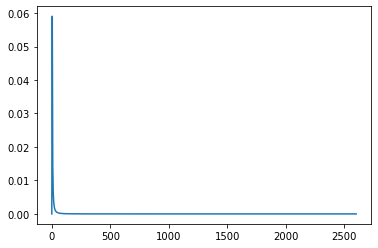

In [17]:
#using our estimated parameters to generate a pareto pdf
output = np.array([scipy.stats.pareto.pdf(x, scale = x̂ₘ, b = α)]) 
plt.plot(x, output.T)
plt.show()

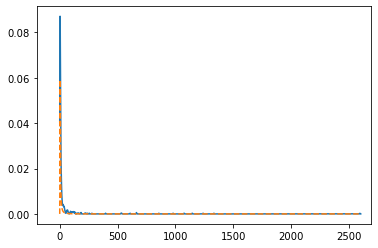

In [18]:
#Overlaying the kernel estimator plot with the pdf for the Pareto distribution with the appropriate parameters.
plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)

output = np.array([scipy.stats.pareto.pdf(x, scale = x̂ₘ, b = α)])
plt.plot(x, output.T, linestyle="--")
plt.show()

## 5. Using GMM estimate the log-Normal distribution that fits the data. Report your results.

In [19]:
#From MM we obtain the following estimates:
μₓ = np.mean(num_stores)
σₓˢ = np.mean(num_stores**2) - μₓ**2

Then all we need to do is transform those variables to be the parameters for a normal distribution, as that is how the lognormal distribution is specified.

So below we have $X \sim lognormal[0,1]$ and $Y \sim normal[0,1]$. And from our sample we can estimate:

$\mu_x = \exp(\mu_y + \frac{\sigma_y^2}{2})$

$\sigma_x^2 = [\exp(\sigma_y^2 - 1)]\exp(2\mu_y + \sigma_y^2)$

Next, we must solfe for $\mu_y, \sigma_y^2$.

In [20]:
# We can use this clever function to solve our system of equations above:
def bsolve(z):
    x = z[0]
    y = z[1]
    
    F = np.empty((2))
    F[0] = np.exp(x + y/2) - μₓ
    F[1] = (np.exp(y)-1)*np.exp(2*x + y) -σₓˢ
    
    return F

zGuess = np.array([2,2])
z = fsolve(bsolve,zGuess)
μ = z[0]
σˢ = z[1]

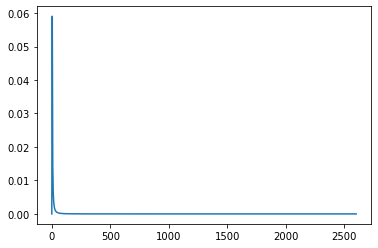

In [21]:
# And finally we can plot the output, which is the lognormal distribution with the appropriate parameters:
output_ln = np.array([scipy.stats.lognorm.pdf(x, scale = np.exp(μ), s = np.sqrt(σˢ))])
plt.plot(x, output.T)
plt.show()

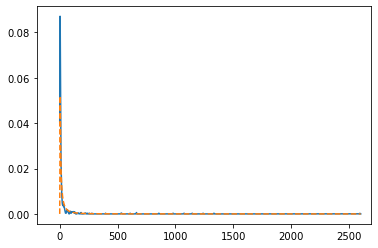

In [22]:
#Overlaying the of the kernel density estimation of the original data with the appropriate lognormal distribution:
plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)

plt.plot(x, output_ln.T, linestyle="--")
plt.show()

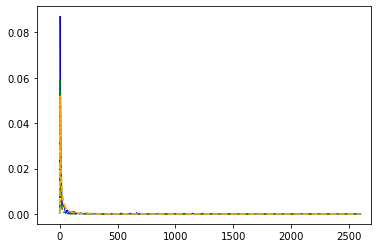

In [23]:
# This isn't super informative, but we can plot the 3 graphs on overlaid:
plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1,
        linestyle="-", color = 'blue')
plt.xlim(-200,np.max(num_stores)+100)

plt.plot(x, output.T,lw = 1.5, linestyle="-.", color = 'green') #Pareto
plt.plot(x, output_ln.T,lw = 1.7, linestyle="--", color = 'orange') #Lognormal
plt.show()

## 6. Using a Kolmogorov-Smirnov test determine whether the log-Normal or the Pareto distribution represent the data. Which one is doing better according the K-S statistics?


In [24]:
pa_args = [α, 0, x̂ₘ]
ks_pareto = scipy.stats.kstest(df.number_of_stores, 'pareto', args=pa_args)
ks_pareto

KstestResult(statistic=0.4542181943088569, pvalue=1.3954194389754329e-120)

In [25]:
ln_args = [np.sqrt(σˢ), 0, np.exp(μ)]
ks_ln = scipy.stats.kstest(df.number_of_stores, 'lognorm', args=ln_args)
ks_ln

KstestResult(statistic=0.1461199829153188, pvalue=2.469290789471845e-12)

In [26]:
table = [
    ['Distribution', 'K-S Stat.', 'P-value'], 
         ['Pareto', round(ks_pareto[0],4), round(ks_pareto[1],4)],
         ['Log_normal', round(ks_ln[0],4), round(ks_ln[1],4)]
        ]
print(tabulate(table))

------------  ---------  -------
Distribution  K-S Stat.  P-value
Pareto        0.4542     0.0
Log_normal    0.1461     0.0
------------  ---------  -------


In [27]:
 ks_ln[1] - ks_pareto[1] >0 

True

We conclude that the Pareto distribution fits the data better, since the K-S statistic is lower, and the P-value is higher (though marginally so) for the log-normal distribution.

Now to show graphically what the K-S test is doing:

In [28]:
from statsmodels.distributions.empirical_distribution import ECDF

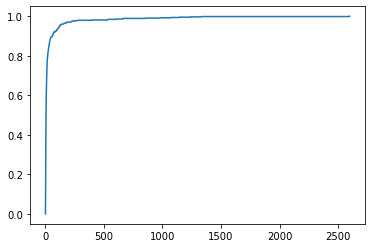

In [29]:
ecdf = ECDF(df.number_of_stores)
x = np.linspace(0,2600,2600)
ecdf_1 = ecdf(x)
plt.plot(x,ecdf_1)

<function matplotlib.pyplot.show(close=None, block=None)>

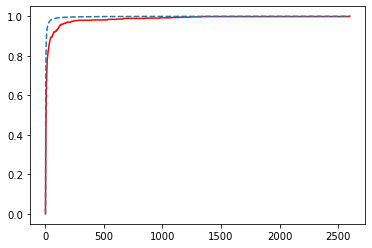

In [30]:
# Here we plot the CDFs for the Pareto and the empirical distributions:
output_pa1 = np.array([scipy.stats.pareto.cdf(x, scale = x̂ₘ, b = α)])
plt.plot(x,ecdf_1, color = "red")
plt.plot(x,output_pa1.T, linestyle = "--")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

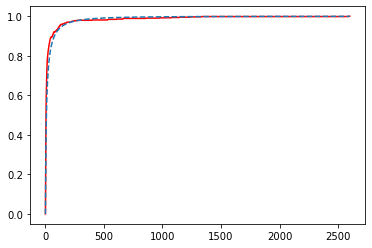

In [31]:
# Here we plot the CDFs for the lognormal and the empirical distributions:
x = np.linspace(0,2600,2600)
output_ln1 = np.array([scipy.stats.lognorm.cdf(x, scale = np.exp(μ), s = np.sqrt(σˢ))])
plt.plot(x,ecdf_1, color = "red")
plt.plot(x,output_ln1.T, linestyle = "--")
plt.show